# Efficient Compressed Sensing SENSE pMRI Reconstruction With Joint Sparsity Promotion
Il Yong Chun, Ben Adcock, and Thomas M. Talavage, 2015

## Julia Implementation

In [2]:
using LinearAlgebra, MAT, FFTW, Wavelets, Random, PyPlot

In [3]:
using SparseArrays

In [4]:
using Distributions 

In [5]:
using Images

### Initialisation

In [6]:
# Load data 
file = matopen("data/brain_coil.mat");
coilScans = read(file, "brain_coil_tmp");
close(file);
file = matopen("data/coil_sensitivity_map.mat");
coilSensitivityMaps = read(file, "coil_map");
close(file);

# # K-spaces
# cs = zeros(64,64,5)
# for i = 1:5
#     cs[:,:,i] =  imresize(coilScans[:,:,i], (64, 64));
# end
# coilScans = cs;
# sm = zeros(64,64,5)
# for i = 1:5
#     sm[:,:,i] =  imresize(coilSensitivityMaps[:,:,i], (64, 64));
# end
# coilSensitivityMaps = sm;
height, width, C = size(coilScans);
N = height*width; # Length of vectorised images

In [7]:
# N = 4
# C = 3
# x = [1 2 3 4 5 6 1 2 3  4 5 6]'  # Example for verification purposes

# Selecting matrix P_Omega in Gaussian distributed fashion
lb = 1;    # The truncation lower bound
ub = N;   # The truncation upper bound
mu = trunc(Int32, N/2)    # The mean of the truncated Normal
sigma = 5000; # The standard deviation of the truncated Normal
d = Truncated(Normal(mu, sigma), lb, ub)  #Construct the distribution type
samp = 5000; # Number of samples with possible overlapping
ind = trunc.(Int64, rand(d, samp)); # Indices of samples (possibly duplicated coordinates here)
A = spzeros(N)
A[ind] .= 1

P_Omega = Diagonal(A);
P_Omega = dropzeros(sparse(P_Omega));

### Utility functions 

In [19]:
a = reshape([1 2; 1 1 ; 1 2; 1 1 ;1 2; 1 1] ,2,2,3)
a[:]

12-element Array{Int64,1}:
 1
 1
 1
 1
 1
 1
 2
 1
 2
 1
 2
 1

In [37]:
# Notation as in Paper
function SoS(x)
    x = reshape(x,N,C)
    x = sum(x.^2, dims = 2)
    return sqrt.(x)
end


function Jsoftshrink(x, lambda)
    x = reshape(x,N,C)
    n = sqrt.(sum(abs.(x).^2, dims = 3));
    x = x ./ n;
    n = n .- lambda;
    n = max.(n, 0);
    y = x .* n;
    return y[:]
end

function Psi(x)
    return dwt(x, wavelet(WT.db2));
end
function Psi_H(x)
    return idwt(x, wavelet(WT.db2));
end
function Phi(x)
    return fftshift(fft(x));
end
function Phi_H(x)
    return ifft(ifftshift(x));
end
function Phi_c(x)
    x = reshape(x,N,C)
    y = zeros(N,C).+0*im
    for i = 1:C
        y[:,i] = Phi(x[:,i]);
    end
    return y[:]
end
function Phi_cH(x)
    x = reshape(x,N,C)
    y = zeros(N,C).+0*im
    for i = 1:C
        y[:,i] = Phi_H(x[:,i]);
    end
    return y[:]
end
function Psi_c(x)
    x = reshape(x,N,C)
    y = zeros(N,C).+0*im
    for i = 1:C
        y[:,i] = Psi(x[:,i]);
    end
    return y[:]
end
function Psi_cH(x)
    x = reshape(x,N,C)
    y = zeros(N,C).+0*im
    for i = 1:C
        y[:,i] = Psi_H(x[:,i]);
    end
    return y[:]
end
function F_Omega_c(x)
    x = reshape(x,N,C)
    y = zeros(N,C).+0*im
    for i = 1:C
        y[:,i] = P_Omega*Phi(x[:,i]);
    end
    return y[:]
end
function F_Omega_cH(x)
    x = reshape(x,N,C)
    y = zeros(N,C).+0*im
    for i = 1:C
        y[:,i] = Phi_H(P_Omega'*x[:,i]);
    end
    return y[:]
end;
# norm(Phi_c(Phi_cH(x)) - x)
# norm(Psi_c(Psi_cH(x)) - x)
# F_Omega_c(F_Omega_cH(x)) - x

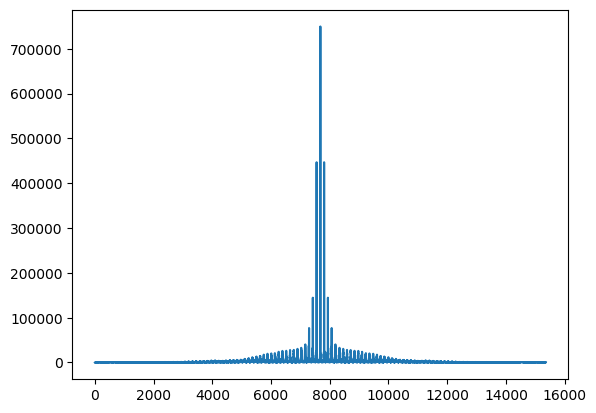

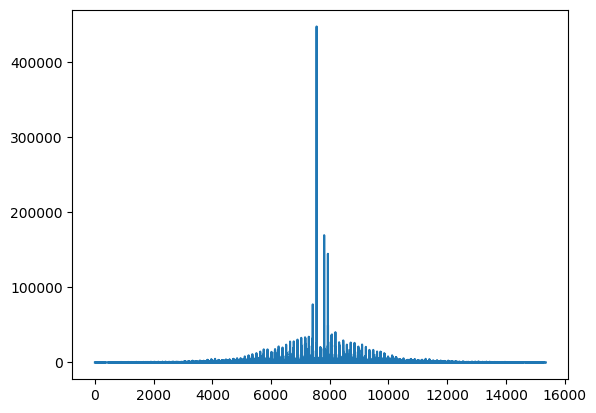

In [38]:
# Simulate K-Space data
cs_vec = reshape(coilScans,:,C)
y_original = zeros(N,C)+zeros(N,C)*im
for i = 1:C
    y_original[:,i] = Phi(cs_vec[:,i]); # Full K-Space data of vectorised coil images
end

y_data = P_Omega*y_original
PyPlot.plot((abs.(y_original[:,1])))
figure()
PyPlot.plot((abs.(y_data[:,1])))
y_data = y_data[:] + randn(C*N); # Added some noise

# Diagonalised Sensitivity Maps
vectorisedMaps = reshape(coilSensitivityMaps, :, C);
S = Diagonal(vectorisedMaps[:,1]);
for coil= 2:C
    S = [S; Diagonal(vectorisedMaps[:,coil])];
end
S = S .+ 0*im; # Very Important to make this complex otherwise Julia gets stuck
# imshow(reshape(cs_vec[:,1],height, width))

In [39]:
# QR Decomposition of S, and defining Q'*x for later use
F = qr(S);
Q = F.Q;
R = F.R;

function Q_H(x)
    y = Q'*x;
    return y[1:N]
end

Q_H (generic function with 1 method)

In [47]:
# Define hyperparameters 
α = 0.05;
beta = 0.1;
v = 0.1;
nInner = 1; # Number of inner Bregman iterations 
nOuter = 10; # Number of outer Bregman iterations 
# delta = # Alternatively can define threshold for stopping condition instead of nOuter

In [48]:
# Precompute values
I_c = Diagonal(ones(C));

PP = α*P_Omega.^2 + (beta + v)*I;
Lambda = kron(I_c, PP) ;
Lambda = Array(diag(Lambda))
function invLambda(x)
     return x./(Lambda)
end

invLambda (generic function with 1 method)

In [49]:
# Initialise values  
y = y_data;
x = SoS(Phi_cH(y));

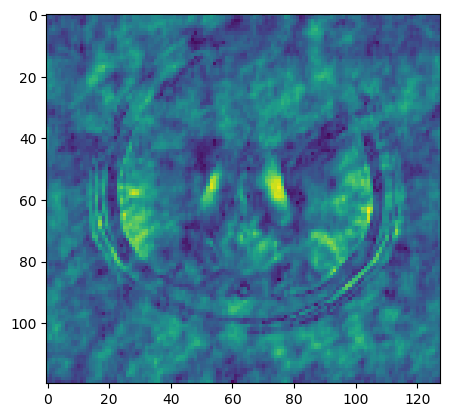

PyObject <matplotlib.image.AxesImage object at 0x000000004223AFC8>

In [50]:
ds = rand(N*C);
dpsi = rand(N*C);
bs = rand(N*C);
bpsi = rand(N*C);
Sx = S*x;
PyPlot.imshow(reshape(abs.(x),height,width))

### SENSE pMRI reconstruction with JS, without the total variation regularization

In [51]:
for nOut = 1:nOuter
    for nIn = 1:nInner
        x = R\(Q_H(ds - bs)); # SOS init will get canceled here
        Sx = S*x;
        ds = Phi_cH(invLambda(Phi_c(α*F_Omega_cH(y) + beta*Psi_cH(dpsi-bpsi) + v*(Sx+bs))));
        dpsi = Jsoftshrink(Psi_c(ds) + bpsi, 1/beta);
        bs = bs + Sx - ds;
        bpsi = bpsi + Psi_c(ds) - dpsi;
    end
    y = y + y_data - F_Omega_c(Sx);
end

In [52]:
norm(y-y_data)

2.6577175175113447e7

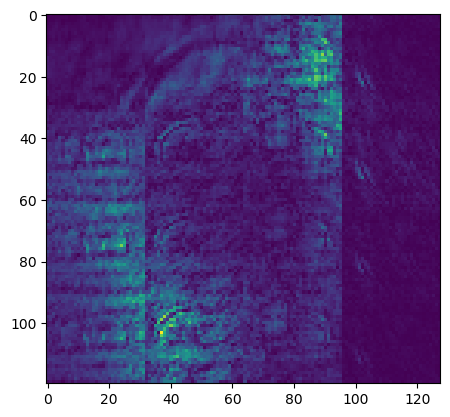

PyObject <matplotlib.image.AxesImage object at 0x00000000422A3608>

In [53]:
PyPlot.imshow(reshape(abs.(x),height,width))

### Visualisation